In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.lines import Line2D

In [16]:
def preprocess_combined_data(df):
    df = df.dropna(subset=['Date'])
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df['PR'] = df['PR'].fillna(df['PR'].mean())
    df['GHI'] = df['GHI'].fillna(df['GHI'].mean())
    df = df.sort_values(by='Date').reset_index(drop=True)
    return df


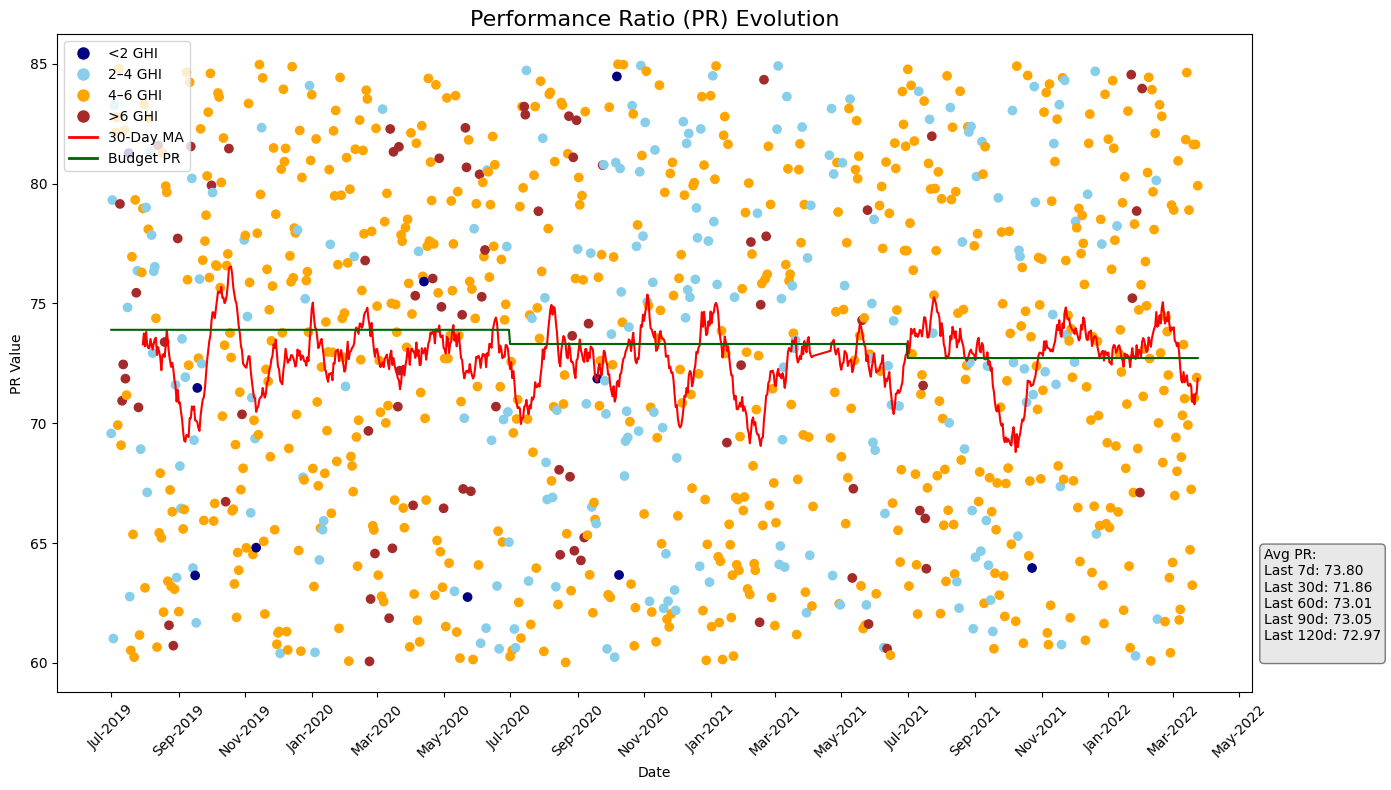

In [20]:
def plot_pr_evolution_with_range(df, start_date=None, end_date=None):
    if start_date:
        df = df[df['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df['Date'] <= pd.to_datetime(end_date)]

    if df.empty:
        print("No data available for the specified date range.")
        return

    df['PR_MA30'] = df['PR'].rolling(window=30).mean()

    df['Budget_PR'] = np.nan
    budget_base = 73.9
    current_budget = budget_base
    min_year = df['Date'].dt.year.min()
    for i in range(10):
        start = pd.Timestamp(year=min_year + i, month=7, day=1)
        end = pd.Timestamp(year=min_year + i + 1, month=6, day=30)
        if start > df['Date'].max():
            break
        mask = (df['Date'] >= start) & (df['Date'] <= end)
        df.loc[mask, 'Budget_PR'] = current_budget
        current_budget *= (1 - 0.008)

    def ghi_color(ghi):
        if ghi < 2:
            return 'navy'
        elif ghi < 4:
            return 'skyblue'
        elif ghi < 6:
            return 'orange'
        else:
            return 'brown'

    colors = df['GHI'].apply(ghi_color)

    # Create the figure and axis inside the function
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.scatter(df['Date'], df['PR'], c=colors, label='Daily PR')
    ax.plot(df['Date'], df['PR_MA30'], color='red', label='30-Day Moving Avg')
    ax.plot(df['Date'], df['Budget_PR'], color='darkgreen', label='Budget PR')

    ax.set_title("Performance Ratio (PR) Evolution", fontsize=16)
    ax.set_xlabel("Date")
    ax.set_ylabel("PR Value")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)

    # Custom legend also inside the same function
    custom_legend = [
        Line2D([0], [0], marker='o', color='w', label='<2 GHI', markerfacecolor='navy', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='2–4 GHI', markerfacecolor='skyblue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='4–6 GHI', markerfacecolor='orange', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='>6 GHI', markerfacecolor='brown', markersize=10),
        Line2D([0], [0], color='red', lw=2, label='30-Day MA'),
        Line2D([0], [0], color='darkgreen', lw=2, label='Budget PR')
    ]
    ax.legend(handles=custom_legend, loc='upper left')

    right_text = "Avg PR:\n"
    for days in [7, 30, 60, 90, 120]:
        avg = df['PR'].tail(days).mean()
        right_text += f"Last {days}d: {avg:.2f}\n"
    props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
    ax.text(1.01, 0.05, right_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props)

    plt.tight_layout()
    plt.show()
    
df = pd.read_csv("combined_output_1.csv")
df_clean = preprocess_combined_data(df)
plot_pr_evolution_with_range(df_clean)